In [1]:
import numpy as np
from matplotlib.image import NonUniformImage
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(style="white")

In [2]:
import sys
sys.path.append("/home/rafalmucha/Pobrane/optic/optics_generator_python/src")

In [3]:
path_to_configuration = "/home/rafalmucha/Pobrane/optic/s/"

In [4]:
x_mean = 0.001
sigma_x = 0.0004
theta_x_mean = 0.0001
sigma_theta_x = 0.0000003
y_mean = 0.001
sigma_y = 0.0006
theta_y_mean = 0.0001
sigma_theta_y = 0.0000003
ksi_mean = 0
sigma_ksi = 0.001

In [5]:
import approximator.madx_runner as mr
import os
import approximator.madxconfigurationgenerator as mc

In [6]:
config_path = path_to_configuration
file_config = "configuration_beam_1_ip_150.xml"

path_to_xml_configuration_file = os.path.join(config_path, file_config)
configuration = mr.load_configuration(path_to_xml_configuration_file)

target = int(configuration["tot_entries_number"])
ready_config_path = mc.generate_configuration_file(config_path, file_config)
output = mr.run_parallel(target, ready_config_path, configuration, 4)

284
636
960
1296
1616
1908
2280


In [38]:
start_segment_name = "start"
end_segment_name = "end"

In [13]:
indexes = output[end_segment_name].T[0].astype(int)

In [17]:
indexes -= 1

In [40]:
input_matrix = output[start_segment_name][indexes]
non_filtered_input_matrix = output[start_segment_name]
# just to distinct between filtered and not
non_filtered_input_matrix.T[1] -= 1

In [21]:
output_matrix = output["end"]

In [74]:
def generate_dataset(x_name, x_index, y_name, y_index, turn_name, turn_index, input_raw, input_filtered, output):
    x_in_raw = input_raw.T[x_index]
    y_in_raw = input_raw.T[y_index]
    turn_in_raw = input_raw.T[turn_index].astype(int)

    frame_in_raw = pd.DataFrame(data={x_name: x_in_raw, y_name: y_in_raw, turn_name: turn_in_raw})

    turn_in = input_filtered.T[turn_index].astype(int)
    x_in = input_filtered.T[x_index]
    y_in = input_filtered.T[y_index]
    frame_in = pd.DataFrame(data={x_name: x_in, y_name: y_in, turn_name: turn_in})

    turn_out = output.T[turn_index].astype(int)
    x_out = output.T[x_index]
    y_out = output.T[y_index]
    frame_out = pd.DataFrame(data={x_name: x_out, y_name: y_out, turn_name: turn_out})

    data_frame = frame_in_raw.append(frame_out)
    data_frame = data_frame.append(frame_in)
    
    mapping = {-1: 'IN: all', 0: 'IN: which passed to OUT', 1: 'OUT'}
    x = data_frame.replace({"turn": mapping})
    
    return x


In [101]:
index_map = {
    "x": 2,
    "theta x": 3,
    "y": 4,
    "theta y": 5,
    "t": 6,
    "pt": 7,
    "s": 8,
    "e": 9
}
meters = " [m]"
radians = " [rad]"
seconds = " [s]"
energy = " [TeV]"
no_unit = " "
unit_map = {
    "x": meters,
    "theta x": radians,
    "y": meters,
    "theta y": radians,
    "t": seconds,
    "pt": no_unit,
    "s": meters,
    "e": energy
}

In [109]:
def plot_with_turn(x_name, y_name, non_filtered_input_matrix, input_matrix, output_matrix, x_pos, y_pos, axes):
    title_sufix = "\n-all particles on input\n-only this which came to end station\n-particles at end station"
    x_index = index_map[x_name]
    y_index = index_map[y_name]
    turn_name = "turn"
    turn_index = 1

    x_full_name = x_name + unit_map[x_name]
    y_full_name = y_name + unit_map[y_name]
    data_frame = generate_dataset(x_full_name, x_index, y_full_name, y_index,\
                                  turn_name, turn_index, non_filtered_input_matrix, input_matrix, output_matrix)

    title = x_name + " and " + y_name + " parameter:" + title_sufix


    sns.scatterplot(x=x_full_name, y=y_full_name,
                    data=data_frame, ax=axes[x_pos][y_pos], hue="turn").set_title(title)

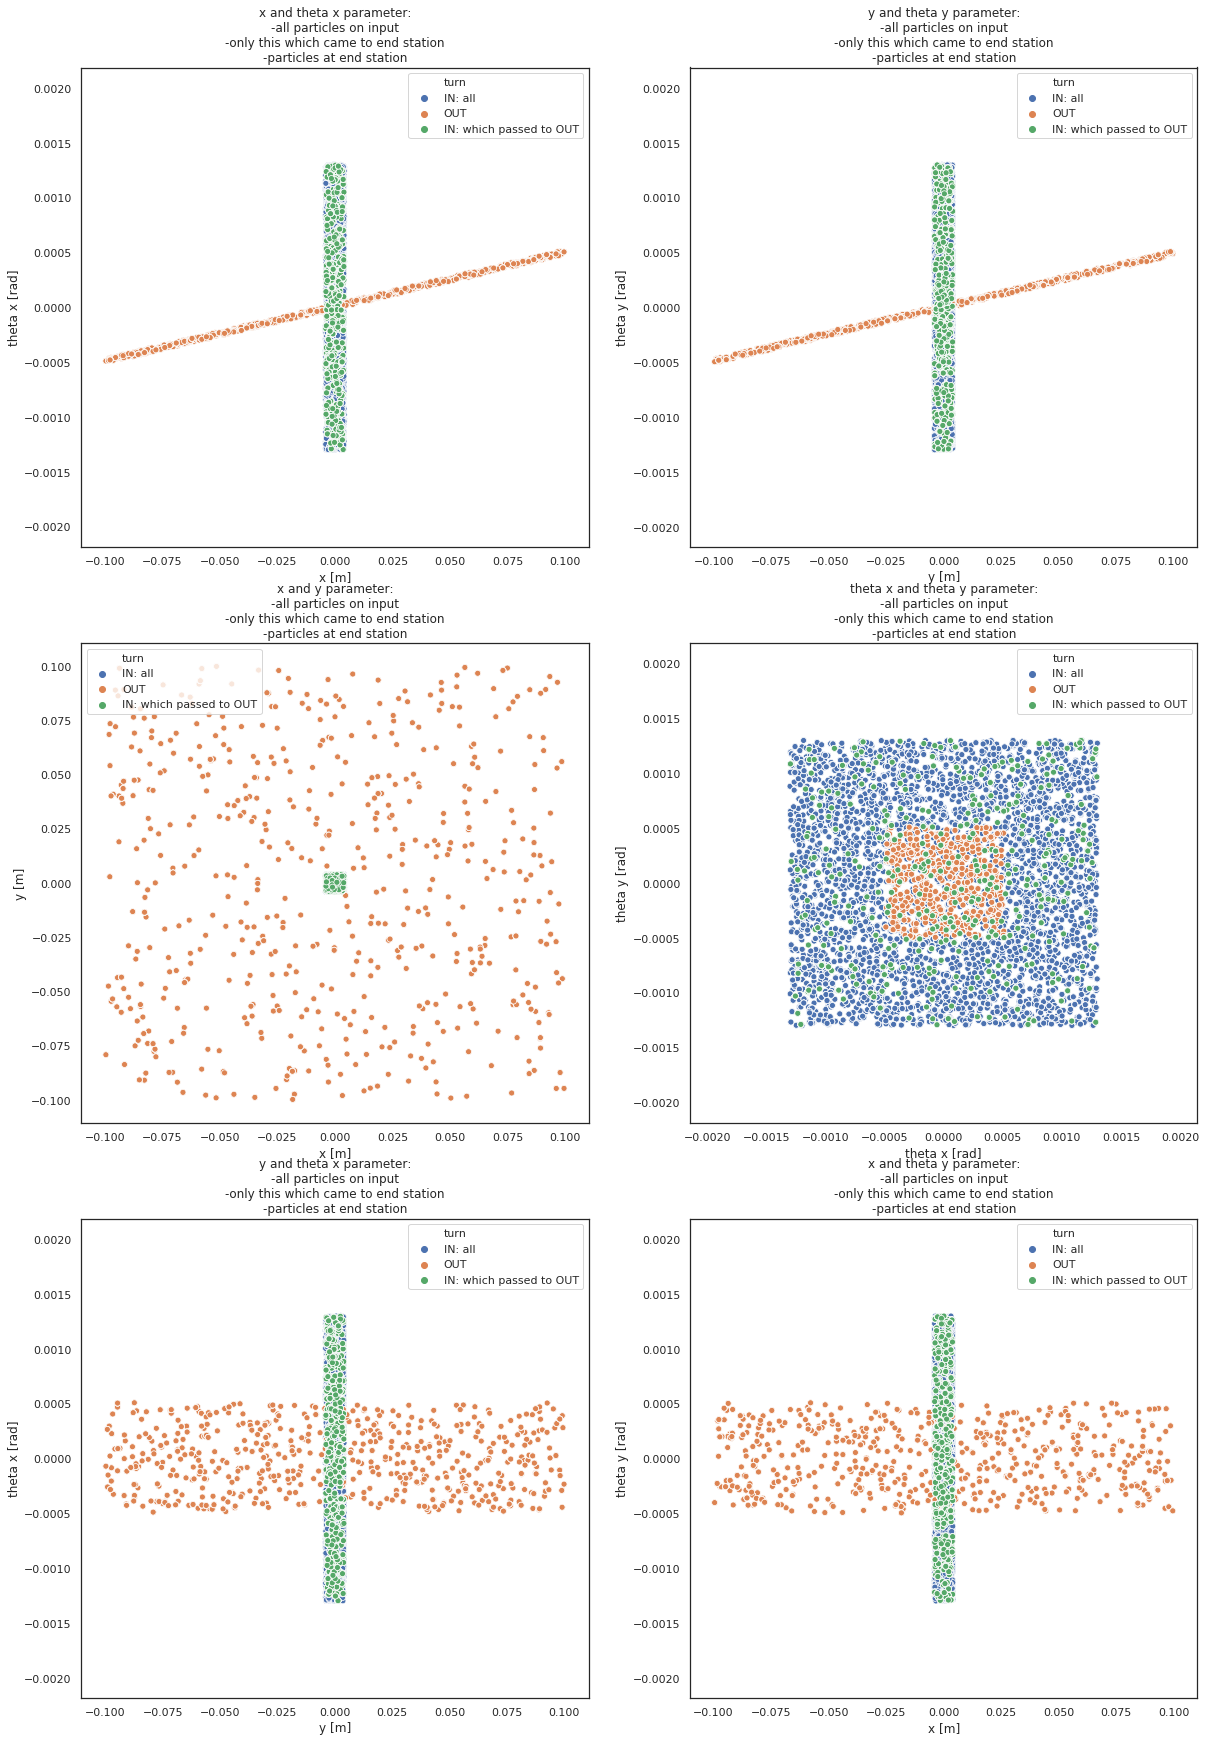

In [111]:
f, axes = plt.subplots(3, 2)

fig = plt.gcf()
fig.set_size_inches(20,30)

plot_with_turn("x", "theta x", non_filtered_input_matrix, input_matrix, output_matrix, 0, 0, axes)

plot_with_turn("y", "theta y", non_filtered_input_matrix, input_matrix, output_matrix, 0, 1, axes)

plot_with_turn("x", "y", non_filtered_input_matrix, input_matrix, output_matrix, 1, 0, axes)

plot_with_turn("theta x", "theta y", non_filtered_input_matrix, input_matrix, output_matrix, 1, 1, axes)

plot_with_turn("y", "theta x", non_filtered_input_matrix, input_matrix, output_matrix, 2, 0, axes)

plot_with_turn("x", "theta y", non_filtered_input_matrix, input_matrix, output_matrix, 2, 1, axes)


In [115]:
def plot_without_turns(x_name, y_name, input_matrix, output_matrix, x_pos, y_pos, axes):
    x_index = index_map[x_name]
    y_index = index_map[y_name]
    
    x = input_matrix.T[x_index]
    y = output_matrix.T[y_index]

    x_full_name = x_name + unit_map[x_name]
    y_full_name = y_name + unit_map[y_name]
    
    frame = pd.DataFrame(data={x_full_name: x, y_full_name: y})

    title = "In " + x_name + " and Out " + y_name + " parameter"

    sns.scatterplot(x=x_full_name, y=y_full_name,
                    data=frame, ax=axes[x_pos][y_pos]).set_title(title)

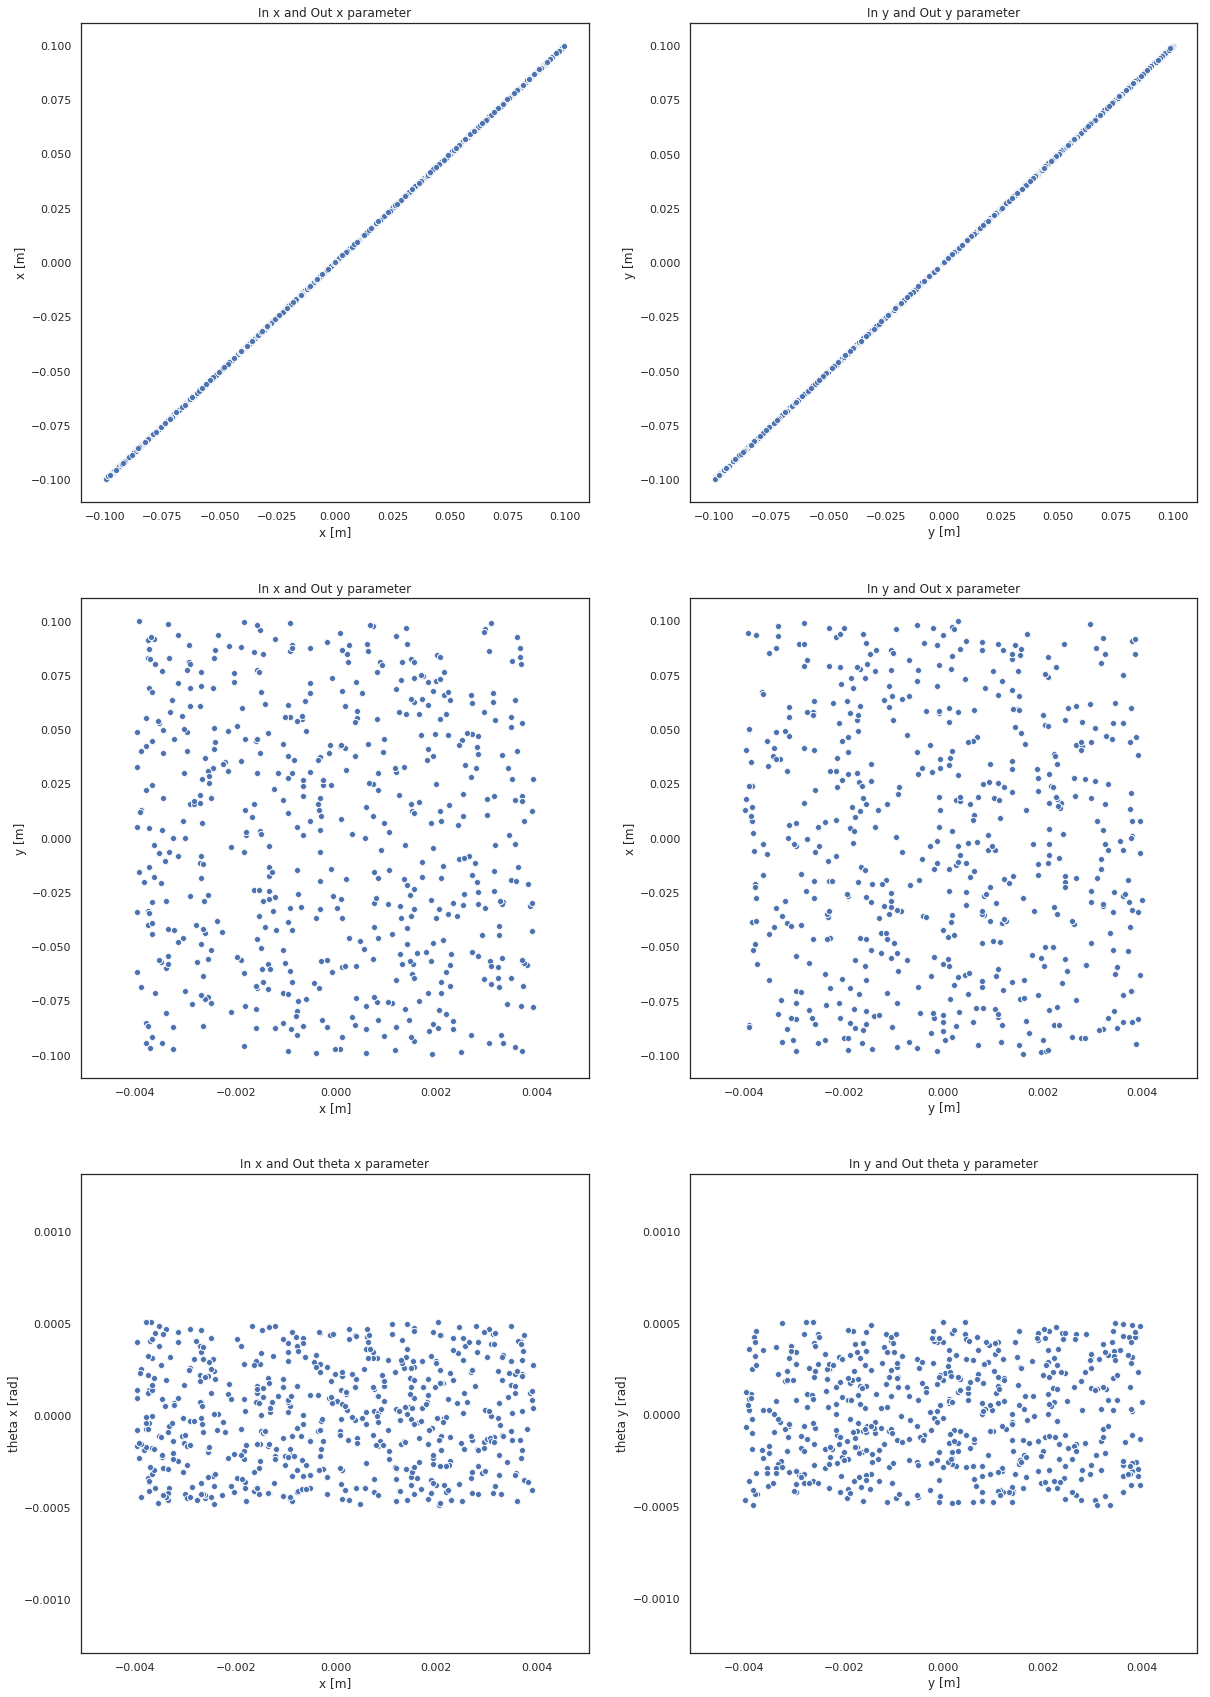

In [117]:
f, axes = plt.subplots(3, 2)

fig = plt.gcf()
fig.set_size_inches(20,30)

plot_without_turns("x", "x", input_matrix, output_matrix, 0, 0, axes)

plot_without_turns("y", "y", input_matrix, output_matrix, 0, 1, axes)

plot_without_turns("x", "y", input_matrix, output_matrix, 1, 0, axes)

plot_without_turns("y", "x", input_matrix, output_matrix, 1, 1, axes)

plot_without_turns("x", "theta x", input_matrix, output_matrix, 2, 0, axes)

plot_without_turns("y", "theta y", input_matrix, output_matrix, 2, 1, axes)

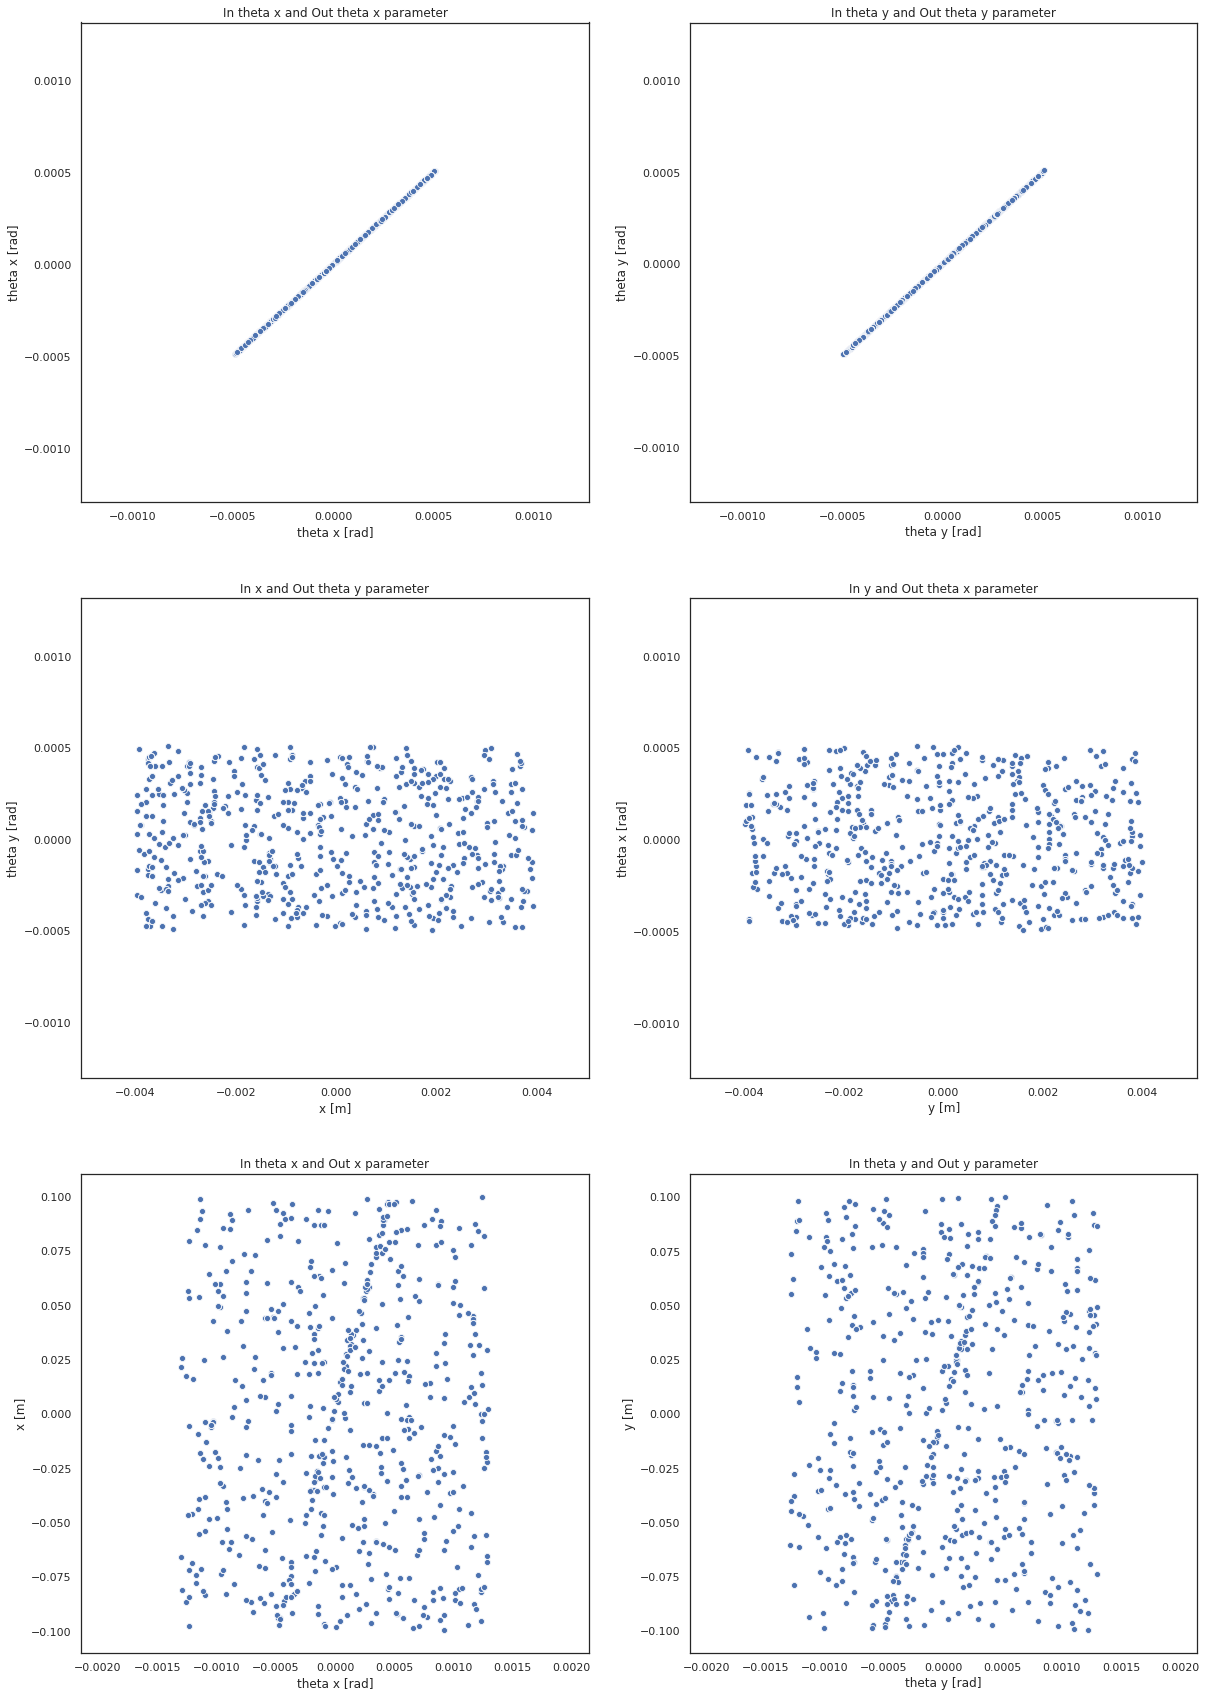

In [118]:
f, axes = plt.subplots(3, 2)

fig = plt.gcf()
fig.set_size_inches(20,30)

plot_without_turns("theta x", "theta x", input_matrix, output_matrix, 0, 0, axes)

plot_without_turns("theta y", "theta y", input_matrix, output_matrix, 0, 1, axes)

plot_without_turns("x", "theta y", input_matrix, output_matrix, 1, 0, axes)

plot_without_turns("y", "theta x", input_matrix, output_matrix, 1, 1, axes)

plot_without_turns("theta x", "x", input_matrix, output_matrix, 2, 0, axes)

plot_without_turns("theta y", "y", input_matrix, output_matrix, 2, 1, axes)


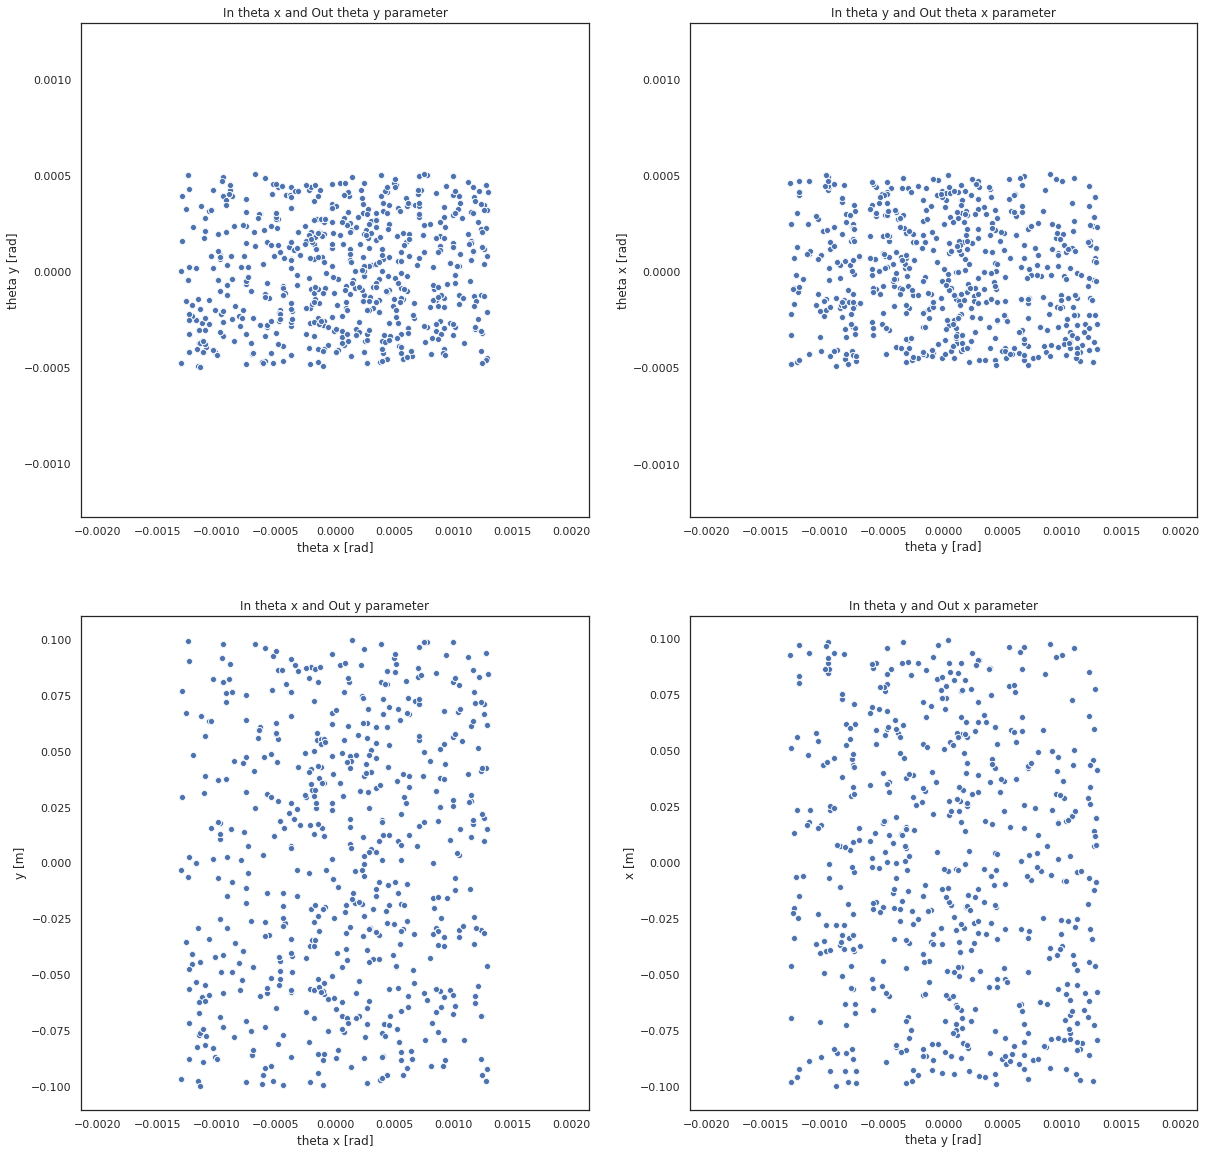

In [119]:
f, axes = plt.subplots(2, 2)

fig = plt.gcf()
fig.set_size_inches(20,20)

plot_without_turns("theta x", "theta y", input_matrix, output_matrix, 0, 0, axes)

plot_without_turns("theta y", "theta x", input_matrix, output_matrix, 0, 1, axes)

plot_without_turns("theta x", "y", input_matrix, output_matrix, 1, 0, axes)

plot_without_turns("theta y", "x", input_matrix, output_matrix, 1, 1, axes)

array([-0.00035718, -0.00035718, -0.00035718, ..., -0.00035718,
       -0.00035718, -0.00035718])